In [1]:
# 다른 경로에 있는 모듈을 가져오기 위해 절대 경로 추가

import os
import sys

root = os.path.join(os.path.abspath(os.getcwd()), '..', '..')
root = os.path.normpath(root)

if root not in sys.path:
    sys.path.insert(0, root)

In [2]:
# 필요한 라이브러리 로드

import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm import tqdm
from transformers import AutoModelForSequenceClassification, AutoTokenizer

/tmp/ipykernel_581255/1932347397.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# 카테고리 정의

CATEGORIES = {
    1: '질문 · 답변',
    2: '학사 · 졸업',
    3: '장학 · 행정',
    4: '학교생활',
    5: '수업/이과',
    6: '수업/문과',
    7: '캠퍼스',
    8: '일상생활',
    9: '취미 · 여가',
    10: '인간관계',
    11: '취업 · 진로',
}

In [4]:
# 커뮤니티 게시글 데이터 로드

from communav.utils import db

connection = db.get_connection()
cursor = connection.cursor()

cursor.execute('''
    SELECT
        articles.id,
        articles.title,
        articles.text,
        labels.category_ids,
        labels.is_verified
    FROM
        everytime_articles articles
    LEFT JOIN
        everytime_article_labels labels ON articles.id = labels.article_id
''')
original_articles = cursor.fetchall()
print(f'Loaded {len(original_articles)} articles.')

cursor.close()
db.close_connection()

Connected to DB successfully.
Loaded 299794 articles.


In [5]:
# 가져온 데이터의 일부를 출력

for article in original_articles[:20]:
    print(article)

{'id': '100001154', 'title': '7급 지역인재 추천 이거 아는 사람?', 'text': '지역인재 추천으로 7급 추천 받을 수 있는 거던데\n이거에 대해 아는 사람 있음?\n전산개발 생각하고있는데', 'category_ids': None, 'is_verified': None}
{'id': '100001868', 'title': '전정대 3학년 되는 학생인데요', 'text': '최근 앱개발에 관심이 생겨서 알아보고 있는데요, 혹시 앱개발과 반도체 관련 전공을 둘다 필요로 하는 부서?직업? 같은게 있나요? 너무 다른 분야라고 생각이 돼서요..', 'category_ids': None, 'is_verified': None}
{'id': '100002646', 'title': '혹시 컴활에 대해 물어보고 싶은분 물어보세요!', 'text': '앙!', 'category_ids': None, 'is_verified': None}
{'id': '100003159', 'title': '공설입 지원금', 'text': '언제들어오냐...', 'category_ids': None, 'is_verified': None}
{'id': '100005572', 'title': '나 너무 배고파 치킨 추천좀!!!', 'text': '메뉴 이름도 알려줘!!!', 'category_ids': None, 'is_verified': None}
{'id': '100005705', 'title': '50대 여성분한테 작별선물 뭐가 좋을까', 'text': '같이 일하시는분한테 드리려고 하는데 되게 잘챙겨주시고 고마웠어서 뭐라도 하나 챙겨드리려고하는데 뭐가좋을까요? 부채같은거 생각했는데.. 괜찮은거 있을까요', 'category_ids': None, 'is_verified': None}
{'id': '100006474', 'title': '자취생의 간단 삼겹살 정식', 'text': '소소한 행복', 'category_ids': None, 'is_verified': None

In [6]:
# 데이터 전처리

contents = [(article['title'] + ' ' + article['text']).strip() for article in original_articles]

In [7]:
# 전처리된 데이터의 일부를 출력

for content in contents[:20]:
    print(content)

7급 지역인재 추천 이거 아는 사람? 지역인재 추천으로 7급 추천 받을 수 있는 거던데
이거에 대해 아는 사람 있음?
전산개발 생각하고있는데
전정대 3학년 되는 학생인데요 최근 앱개발에 관심이 생겨서 알아보고 있는데요, 혹시 앱개발과 반도체 관련 전공을 둘다 필요로 하는 부서?직업? 같은게 있나요? 너무 다른 분야라고 생각이 돼서요..
혹시 컴활에 대해 물어보고 싶은분 물어보세요! 앙!
공설입 지원금 언제들어오냐...
나 너무 배고파 치킨 추천좀!!! 메뉴 이름도 알려줘!!!
50대 여성분한테 작별선물 뭐가 좋을까 같이 일하시는분한테 드리려고 하는데 되게 잘챙겨주시고 고마웠어서 뭐라도 하나 챙겨드리려고하는데 뭐가좋을까요? 부채같은거 생각했는데.. 괜찮은거 있을까요
자취생의 간단 삼겹살 정식 소소한 행복
문과는 올바른 가치관을 가져야 하고 이 사회를 공부해서 잘 운영해야하고 이과는 이 세상을 발전시켜야하는데 세상 꼬라지나 우리나라 꼬라지 보면 문과들은 공부 안하는게 맞다 기술은 발전하는데 인간들이 발전 못하네
채널돌리다 복면가왕봤는데 대놓고 소찬휘네 ㄲㅋㅋ
사람머리뼈 ㄷㄷ
공머생 말좀 묻겠수다 노트북 다들 뭐쓰쇼?
사는게 고민인 너네완 다르게 사는게 고민 하~!
학교근처에서 밥 배달시켜먹을라는데 추천좀! 배민이나 요기요에서 시킬라하는데 추천좀!
돈은 크게 상관없음
중화사상 옛날 중화사상 = 황제국, 상전 대접을 받는 대신 경제적, 군사적 지원을 조.공국들에게 넉넉하게 베푸는 암묵적 거래.
지금 "짱깨"의 중화사상 = 몽골 야만족 원나라식으로 힘으로 누르고 돈과 자원을 뺏어옴. 나중에 짱깨가 흔들리면 뒷통수 박살나게 됨.
그리고 중화사상은 유교적인것 이기도 해서 "중국은 최고다 - 조.공국들에게 군자로써 모범을 보여야한다"가 패시브로 있었는데
공산당이 집권하고 "중공" "짱깨"가 되면서 "유교"와 "군자로써 모범을 보여야 한다"가 빠지고 "중국은 최고다"만 남음.
오히려 경제적, 군사적 지원을 나눠주고 상전 대접을 받는 외교는 미국이 하는 방식이 됨.
개성있는 자

In [8]:
# 파라미터 정의

MODEL_ID = 'model-iteration-42-epoch-18-0.9448'
MAX_LENGTH = 128
BATCH_SIZE = 32
TARGET_CATEGORY = 5
THRESHOLD = 0.95

In [9]:
# 토크나이저 로드

tokenizer = AutoTokenizer.from_pretrained(MODEL_ID)

print('Original:', contents[0])
print('Tokenized:', tokenizer.tokenize(contents[0]))

Original: 7급 지역인재 추천 이거 아는 사람? 지역인재 추천으로 7급 추천 받을 수 있는 거던데
이거에 대해 아는 사람 있음?
전산개발 생각하고있는데
Tokenized: ['7', '##급', '지역', '##인', '##재', '추천', '이거', '아는', '사람', '?', '지역', '##인', '##재', '추천', '##으로', '7', '##급', '추천', '받을', '수', '있는', '거', '##던데', '이거', '##에', '대해', '아는', '사람', '있음', '?', '전산', '##개발', '생각하고', '##있는데']


In [10]:
# 모델 로드

if torch.cuda.is_available():
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('No GPU available, using the CPU instead.')

model = AutoModelForSequenceClassification.from_pretrained(MODEL_ID, num_labels=2)
model.to(device)

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 3060 Ti


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [11]:
# 텍스트 인코딩 및 데이터셋 생성

encodings = tokenizer(
    contents,
    padding=True,
    truncation=True,
    return_tensors='pt',
    max_length=MAX_LENGTH
)
dataset = torch.utils.data.TensorDataset(
    torch.tensor(encodings['input_ids']),
    torch.tensor(encodings['attention_mask'])
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=False)

/tmp/ipykernel_581255/3188963195.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(encodings['input_ids']),
/tmp/ipykernel_581255/3188963195.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(encodings['attention_mask'])


In [12]:
# 추론

inference_results = [0] * len(original_articles)

for i, batch in enumerate(tqdm(dataloader, desc='Inference')):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)

    start_idx = i * BATCH_SIZE
    end_idx = start_idx + BATCH_SIZE
    inference_results[start_idx:end_idx] = probabilities[:, 1].tolist()

df_results = pd.DataFrame(original_articles)
df_results[f'category_{TARGET_CATEGORY}'] = inference_results
df_results[f'category_{TARGET_CATEGORY}_is_valid'] = None
df_results.sort_values(by=f'category_{TARGET_CATEGORY}', ascending=False, inplace=True)

print('Inference finished.')

Inference: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9369/9369 [18:24<00:00,  8.48it/s]


Inference finished.


In [13]:
# 추론 결과의 일부를 출력

df_results.head(20)

,id,title,text,category_ids,is_verified,category_5,category_5_is_valid
5905,110285901,전자기학2..,2학기긴 한데 2학년 전기공학 전자기학2 전필이야?? \n전자기학 1만 전필이면 재...,None,NaN,0.999546,None
222187,330406018,기초전자회로및실험 팀플,목요일 날 3교시하고 금욜날 1교시하는 수업의 경우 금요일은 뭐하는건가요? 목요일은...,None,NaN,0.999545,None
192096,303944043,대학수학2 계절로 재수강 들으려는데,저희과는 대학수학2가 기선 3학점인데 계절은 기필 3학점인데 대체가능할까요?,None,NaN,0.999543,None
111436,230954168,대수랑 이산수학 같이듣기 힘든가요?,1학년때 대수 안들어서 들으려는데 공수는 계절로 뺄거고 이산수학 같이들어도 될지 고...,None,NaN,0.999543,None
238625,41882881,대학물리1 정용환 교수님 시험범위,대학물리1 정용환 교수님 월1 수3 4 교시 시험범위와 시험 보는날 알수 있을가요?,None,NaN,0.999543,None
15253,124754686,c프,c프 과젠데 문제 이해를 못하겠어요\n제가 숫자를 입력하면 a배열에서 짝수만 출력하...,None,NaN,0.999540,None
20026,129502677,대학물리1 ㅈㄱㅅ 교수님 3차과제,3차과제 메일로 보낸지 2주일 넘었는데 아직 안 읽으신 분 있나요? 제가 보낸건 아...,None,NaN,0.999540,None
165253,278399610,컴사 계절학기 질문,컴퓨팅사고 계절학기에서는 c프로그래밍으로 바뀌어서 나오는거 맞나요? 소융대입니다,None,NaN,0.999539,None
26040,137230041,컴공 전자회로 안들으면 힘든가요?,이수체계도 보니깐 컴기실2하고 다음학기 컴구로 이어지던데 많이 연결되있나요?,None,NaN,0.999538,None
111004,230728203,진공공학이랑 반도체소자공학,전재과 3학년입니당 진공공학이랑 반도체소자공학 못잡았는데 나중에 열어주시나요???,None,NaN,0.999536,None


In [14]:
# 추론 결과를 CSV 파일로 저장

df_results.to_csv('labeling-results.csv', index=False)

Other: 276027 (92.07%)
Target: 23767 (7.93%)


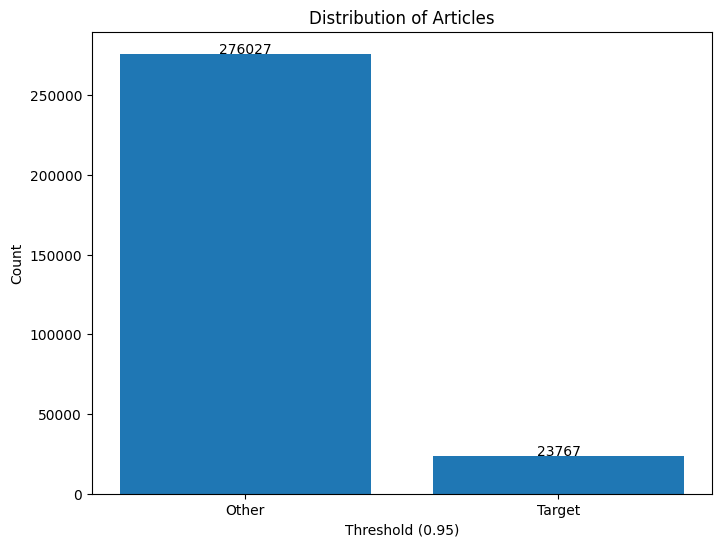

In [15]:
# 추론 결과의 비율을 출력

other_threshold_count = 0
target_threshold_count = 0

for result in inference_results:
    if result >= THRESHOLD:
        target_threshold_count += 1
    else:
        other_threshold_count += 1

total_count = len(inference_results)
other_threshold_percentage = other_threshold_count / total_count * 100
target_threshold_percentage = target_threshold_count / total_count * 100

print(f'Other: {other_threshold_count} ({other_threshold_percentage:.2f}%)')
print(f'Target: {target_threshold_count} ({target_threshold_percentage:.2f}%)')

plt.figure(figsize=(8, 6))
plt.bar(['Other', 'Target'], [other_threshold_count, target_threshold_count])
plt.text(0, other_threshold_count + 0.1, str(other_threshold_count), ha='center')
plt.text(1, target_threshold_count + 0.1, str(target_threshold_count), ha='center')
plt.xlabel(f'Threshold ({THRESHOLD})')
plt.ylabel('Count')
plt.title('Distribution of Articles')
plt.show()